In [95]:
import glob
import json
import os

import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import soundfile as sf 

import utils
import plots_improved

# listen to audios
import IPython.display as ipd

In [96]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
%autoreload 2

In [98]:
# dataset_path = "/media/gigibs/DD02EEEC68459F17/datasets"
# dataset_path = "/scratch/gv2167/datasets/"
dataset_path = "/home/gigibs/Documents/datasets"

In [99]:
qfs = pd.read_json("../data/output_data/qwen_fs.json")
qfs = utils.parse_df(qfs, experiment_name="qwen_fs")


qzs = pd.read_json("../data/output_data/qwen_zs.json")
qzs = utils.parse_df(qzs, experiment_name="qwen_zs")

In [125]:
def get_shapley_values(row):
    question_id =  row.name
    
    data = f"../{row['output_folder']}/{question_id}_info.npz"
    data = np.load(data)
    tokens = row["input_ids"]
    audio_tokens = np.where(tokens < 0)[-1]
    question_tokens = np.where(tokens >= 0)[-1]
    
    all_shapley_values = data["shapley_values"].squeeze(0).squeeze(0)
    audio_shapley_values = all_shapley_values[audio_tokens]
    question_shapley_values = all_shapley_values[question_tokens]

    return all_shapley_values, audio_shapley_values, question_shapley_values

def weight_important_features(audio, audio_shapley_values):
    """
    given an audio and its shapley values, apply the magnitude to the audio windows and 
    return the processed audio
    """
    # Calculate segment length
    total_length = len(audio)
    num_segments = len(audio_shapley_values)
    segment_length = total_length // num_segments
    
    processed_audio = np.zeros_like(audio)
    
    for i, magnitude in enumerate(audio_shapley_values):
        start_idx = i * segment_length
        end_idx = (i + 1) * segment_length
        
        # For the last segment, include any remaining samples
        if i == num_segments - 1:
            end_idx = total_length
        
        processed_audio[start_idx:end_idx] = audio[start_idx:end_idx] * magnitude

    return processed_audio

def save_qual_results(sample, img_format="pdf"):
    if sample["experiment"].startswith("qwen"):
        sample_rate = 16000
    else:
        sample_rate = 24000

    # FIXME: make this a parameter
    gt_start = 5.6
    gt_end = 7
    
    x, fs = librosa.load(os.path.join(dataset_path, sample.audio_path), sr=sample_rate)
    all_shapley_values, audio_shapley_values, question_shapley_values = get_shapley_values(sample)

    
    output_folder = f"{sample['experiment']}_{sample.name}"
    os.makedirs(output_folder, exist_ok=True)
    print("saving data in ", output_folder)
    
    # generate plot per whole output
    plots_improved.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=sample_rate,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=None,
        figsize=(12,7),
        colormap="binary",
        threshold=0.8, 
        save_folder=output_folder,
        show_image=False,
        output_format=img_format
    )

    positive_contrib = np.clip(audio_shapley_values, a_min=0, a_max=None).sum(axis=1)
    neg_contrib = np.clip(audio_shapley_values, a_min=None, a_max=0).sum(axis=1)
    agg_contrib = audio_shapley_values.sum(axis=1)
   
    pos_wav = weight_important_features(x, positive_contrib)
    neg_wav = weight_important_features(x, neg_contrib)
    # agg_wav =  weight_important_features(x, agg_contrib)
    sf.write(os.path.join(output_folder, "agg_positive.wav"),  pos_wav, sample_rate)
    sf.write(os.path.join(output_folder, "agg_negative.wav"), neg_wav, sample_rate)
    # sf.write(os.path.join(output_folder, "agg_abs.wav"), agg_wav, sample_rate)

    # generate plots per token
    for i, t in enumerate(sample["output_tokens"]):
        print("output_token = ", t)
        highlighted_text = plots_improved.visualize_shapley_analysis(
                text_shapley_values=question_shapley_values,
                question_tokens=sample["input_tokens"],
                answer_tokens=sample["output_tokens"],
                audio_signal=x,
                audio_shapley_values=audio_shapley_values,
                sample_rate=sample_rate,
                gt_start=gt_start,
                gt_end=gt_end,
                idx=i,
                figsize=(12,7),
                colormap="binary",
                threshold=0.3, 
                save_folder=output_folder,
                show_image=False,
                output_format=img_format
            )

        positive_contrib = np.clip(audio_shapley_values[:, i], a_min=0, a_max=None)
        neg_contrib = np.clip(audio_shapley_values[:, i], a_min=None, a_max=0)
        agg_contrib = audio_shapley_values[:, i]
        pos_wav = weight_important_features(x, positive_contrib)
        neg_wav = weight_important_features(x, neg_contrib)
        # agg_wav =  weight_important_features(x, agg_contrib)
        
        sf.write(os.path.join(output_folder, f"{i}_{t}_positive.wav"), pos_wav, sample_rate)
        sf.write(os.path.join(output_folder, f"{i}_{t}_negative.wav"), neg_wav, sample_rate)
        # sf.write(os.path.join(output_folder, f"{i}_{t}_abs.wav"), agg_wav, sample_rate)

    with open(os.path.join(output_folder, f"{output_folder}.txt"), "w") as f:
        f.write(sample["model_output"])
        
    return

In [126]:
# annotations for this audio
gt_start = 5.6
gt_end = 7

In [127]:
sample = qzs.loc[719]

all_shapley_values, audio_shapley_values, question_shapley_values = get_shapley_values(sample)

x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=16000)
ipd.Audio(x, rate=fs)

saving data in  qwen_zs_719
text_max 10.5257568359375, text_min -7.430732727050781, text_median 1.42889404296875
audio_max 5.54736328125, audio_min -1.07513427734375, audio_median 0.325927734375
max_abs_value 10.5257568359375
output_token =  The
text_max 0.796875, text_min -0.359375, text_median 0.09375
audio_max 0.125, audio_min -0.203125, audio_median 0.015625
max_abs_value 4.7060546875
output_token =   sound
text_max 1.181640625, text_min -0.66064453125, text_median 0.00390625
audio_max 0.515625, audio_min -0.08984375, audio_median 0.0234375
max_abs_value 4.7060546875
output_token =   effect
text_max 4.40625, text_min -2.052734375, text_median -0.037109375
audio_max 0.76953125, audio_min -0.2705078125, audio_median 0.03125
max_abs_value 4.7060546875
output_token =   that
text_max 0.896484375, text_min -0.724609375, text_median 0.05859375
audio_max 0.451171875, audio_min -0.1982421875, audio_median 0.03125
max_abs_value 4.7060546875
output_token =   can
text_max 3.04248046875, text_m

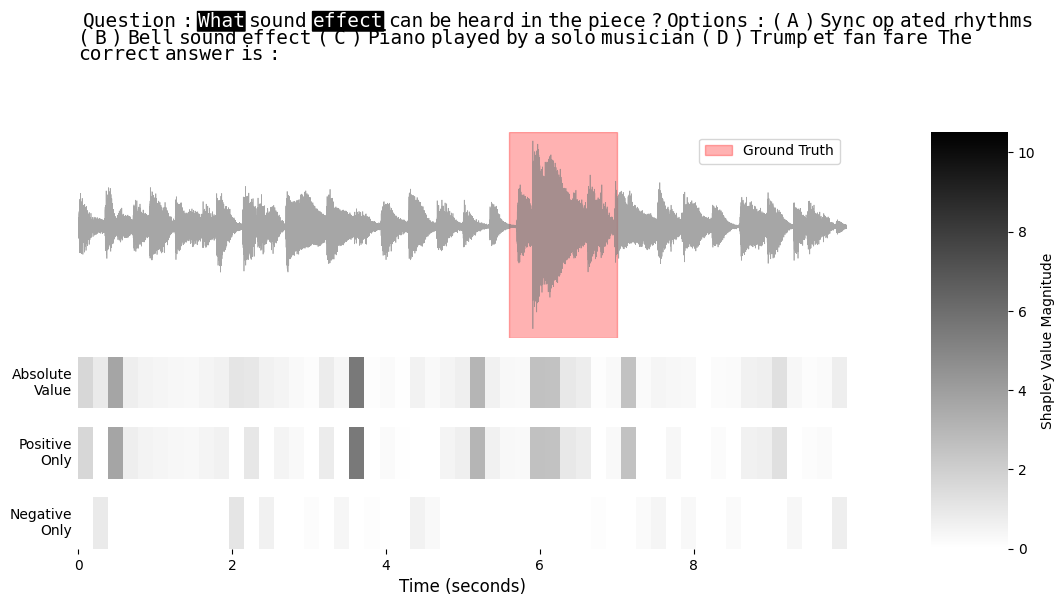

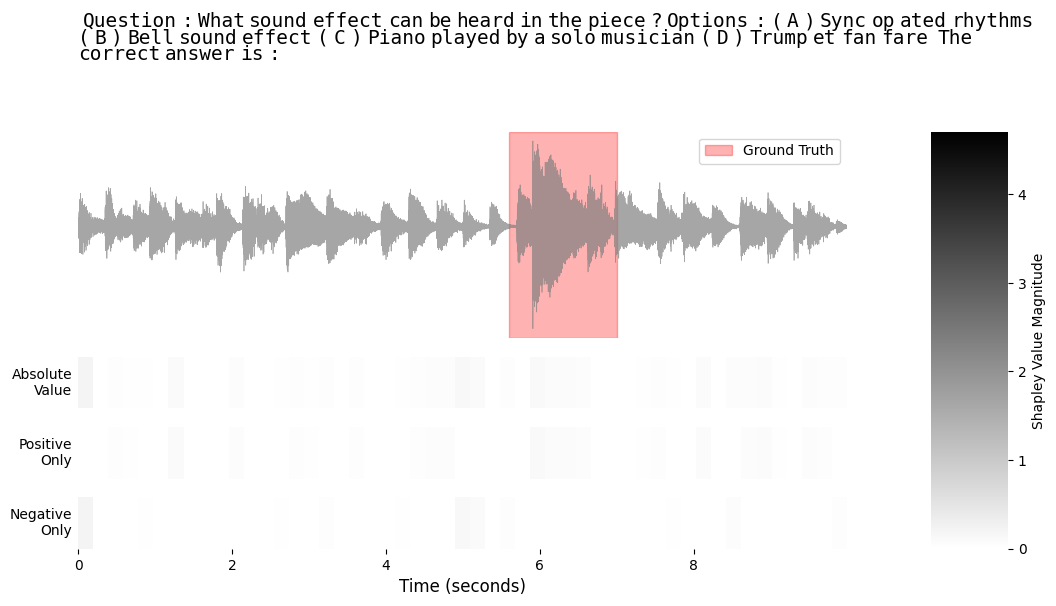

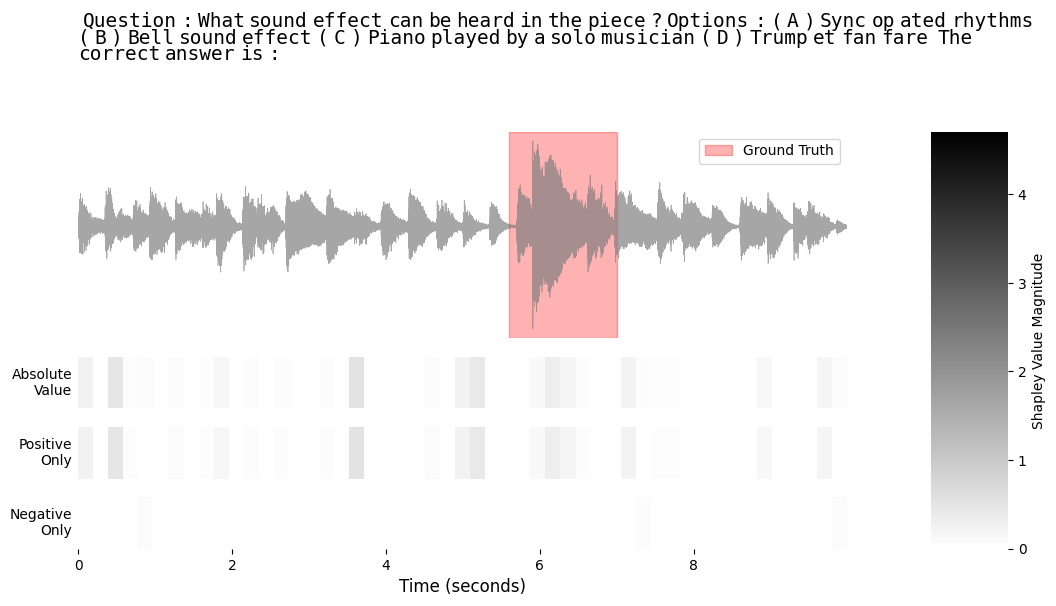

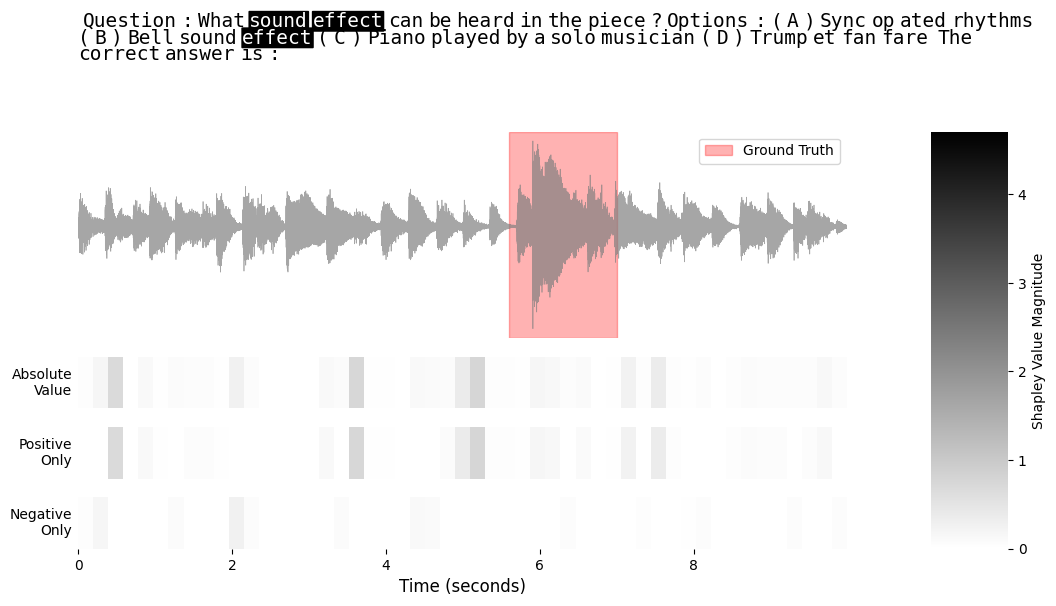

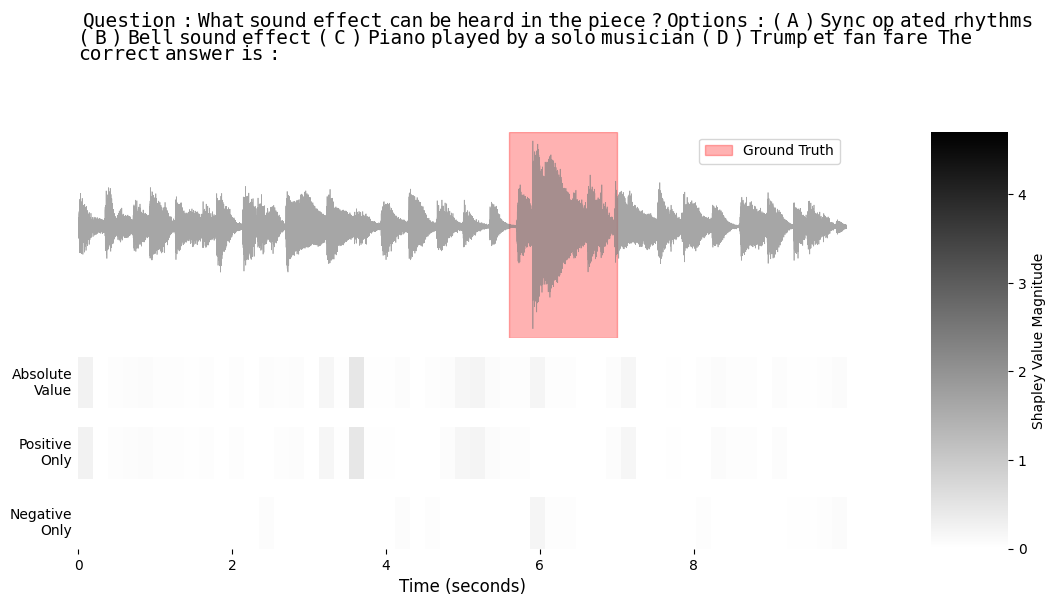

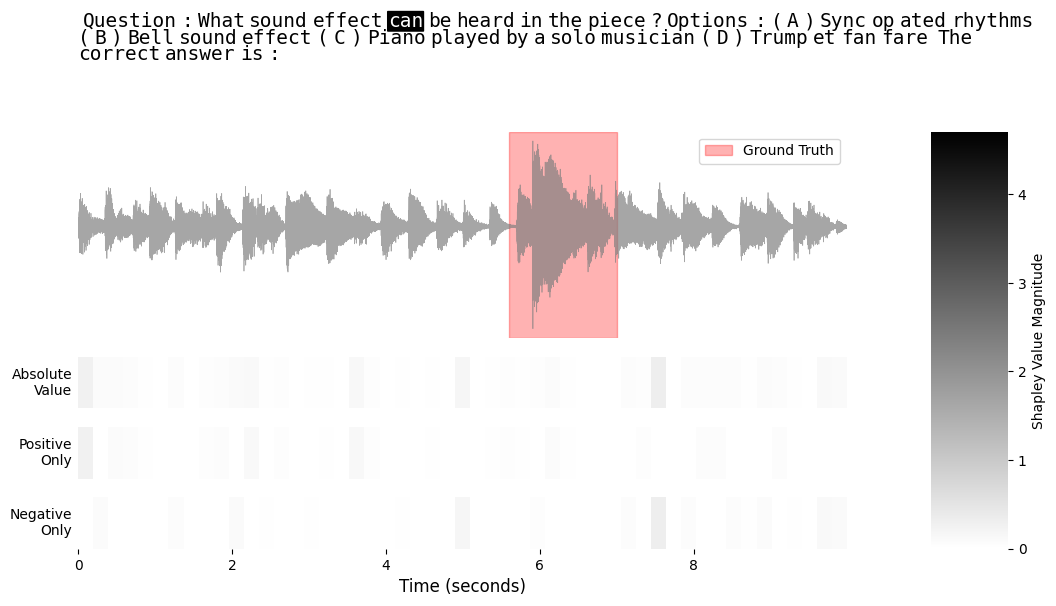

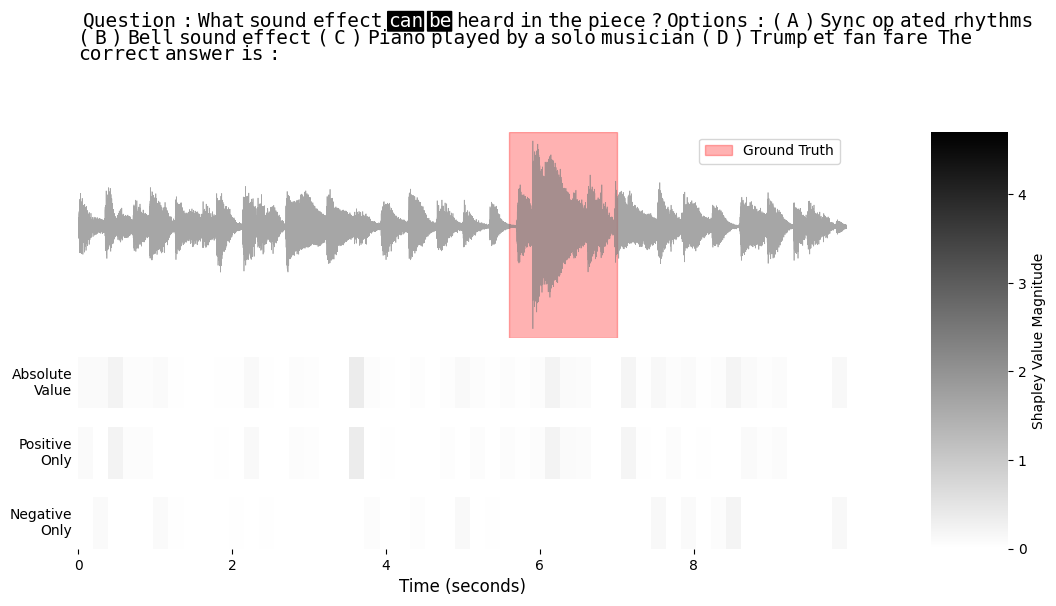

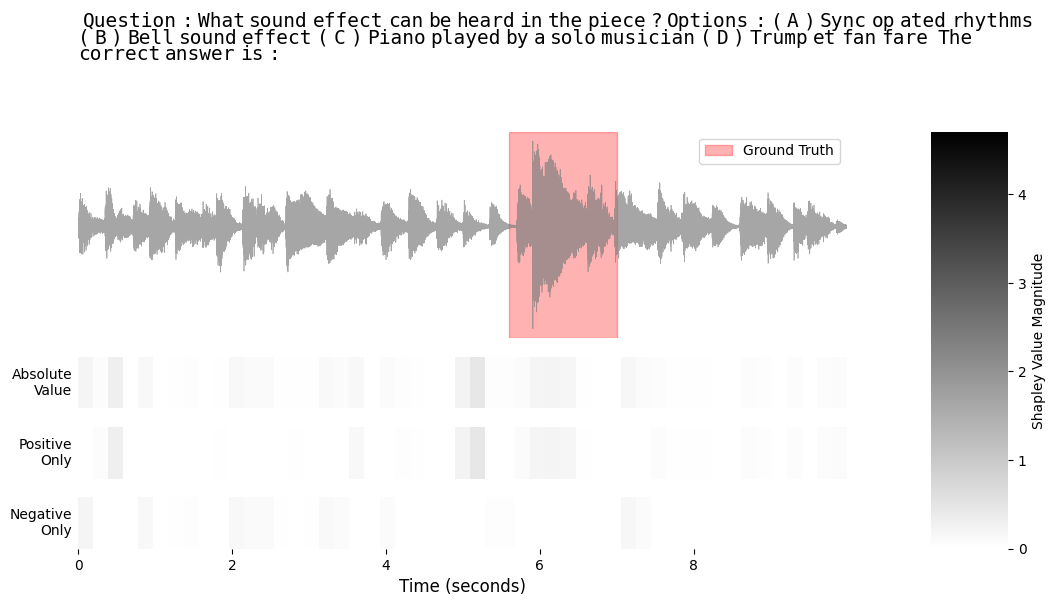

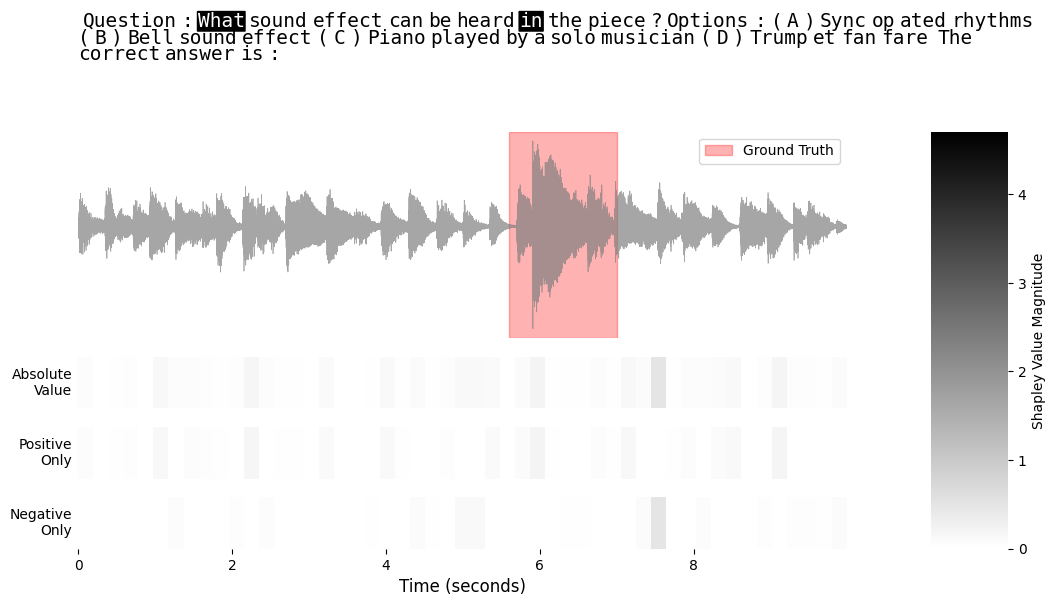

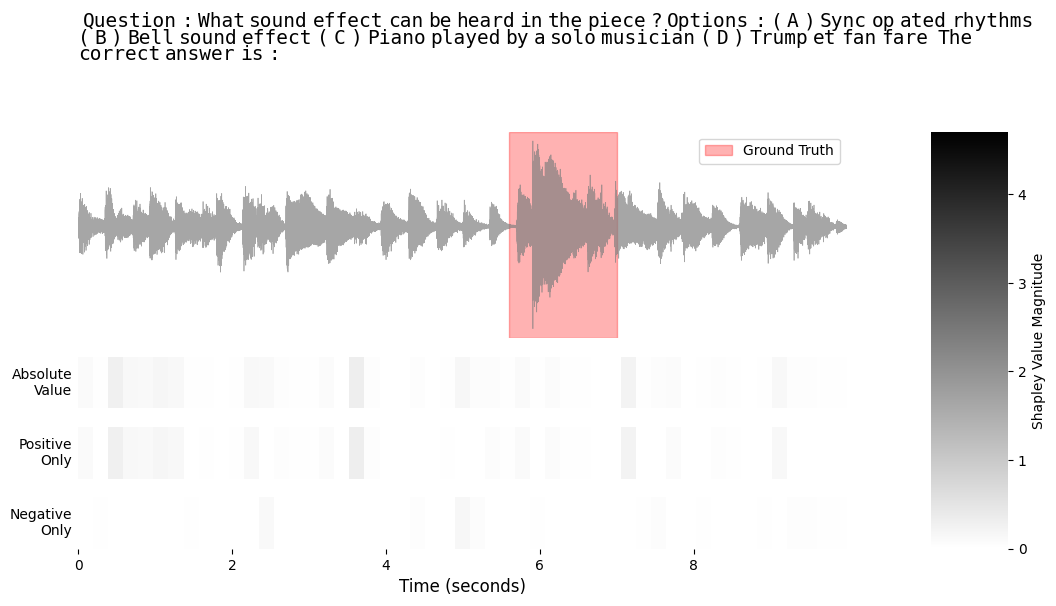

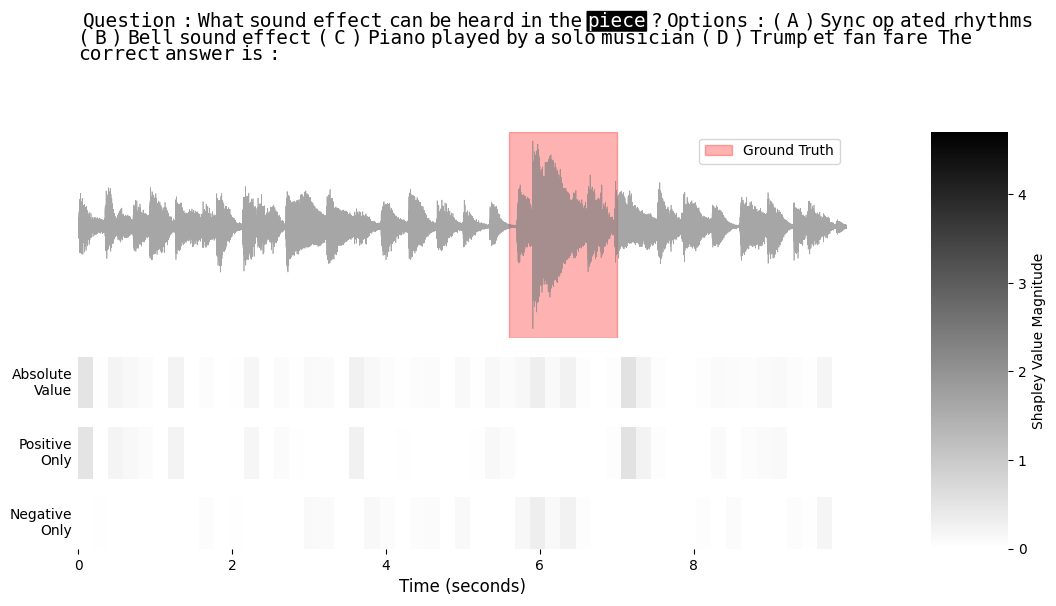

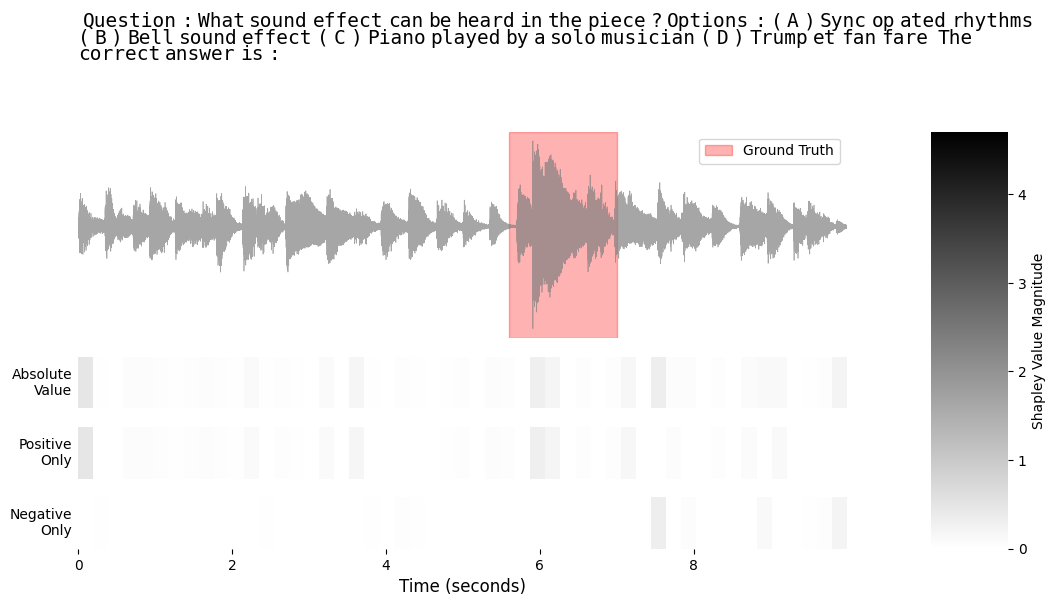

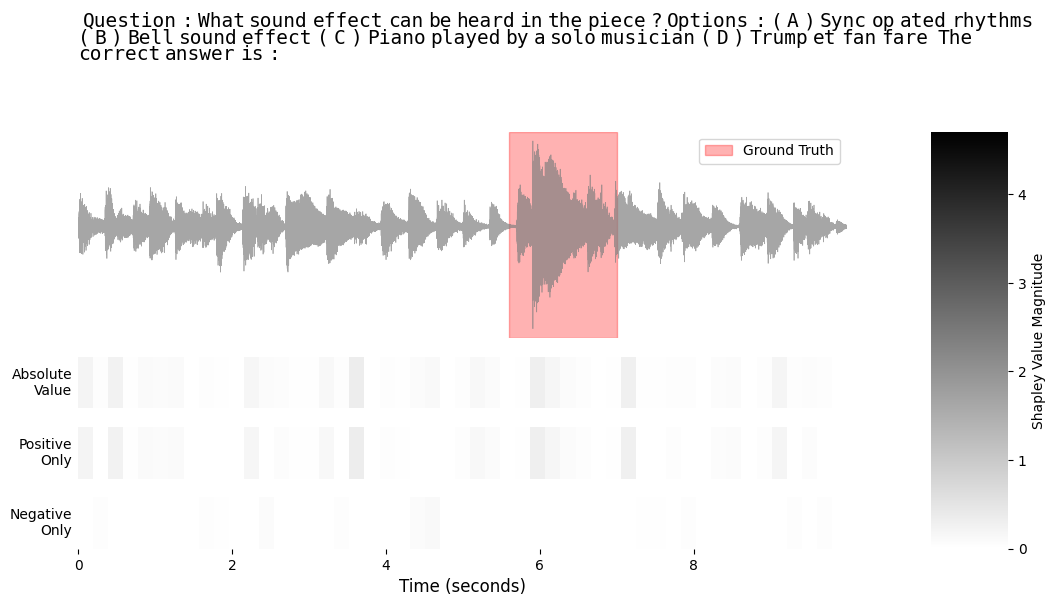

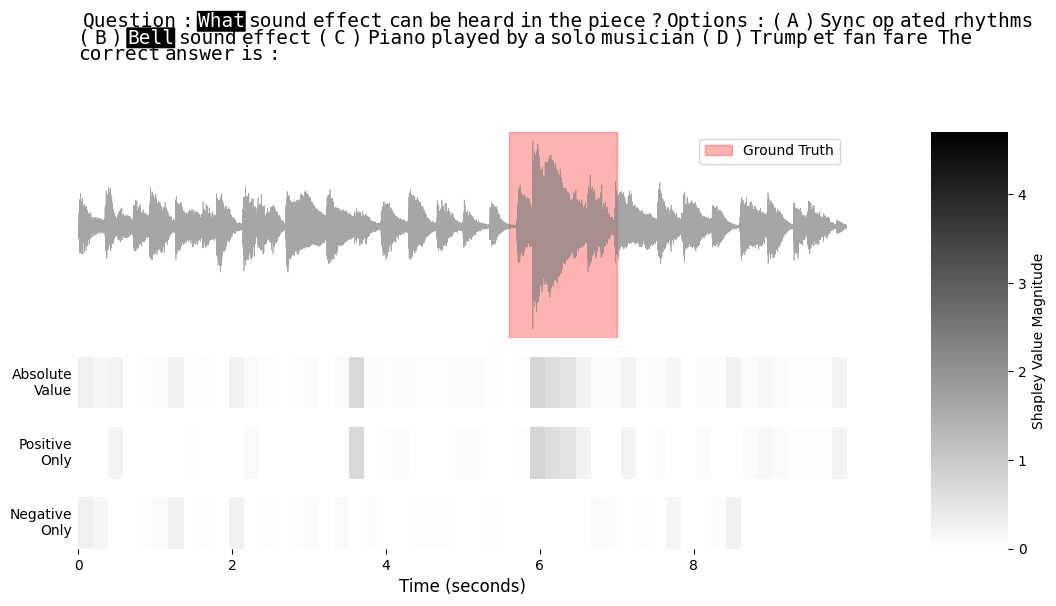

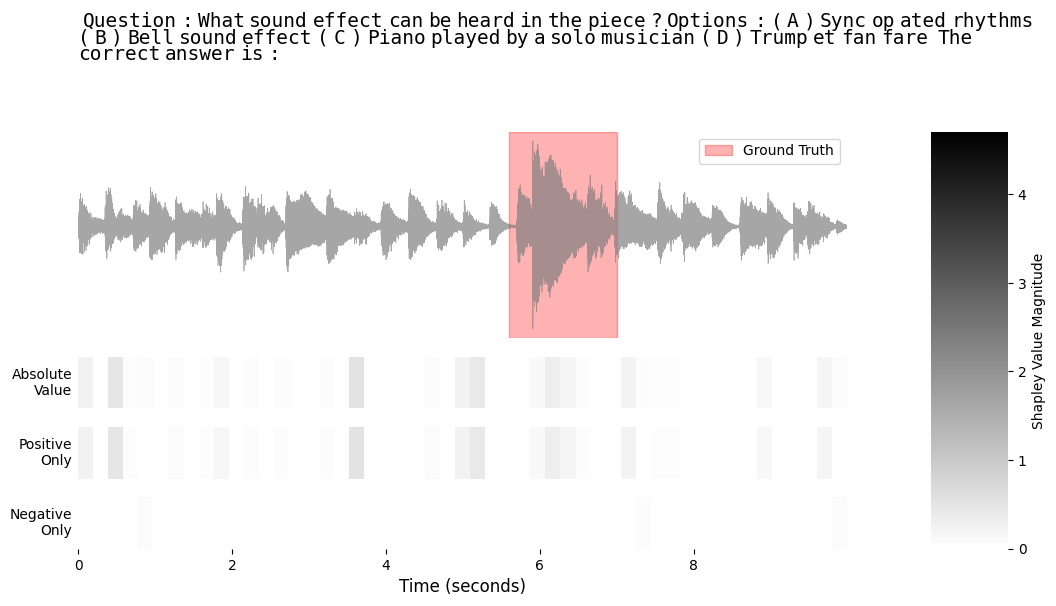

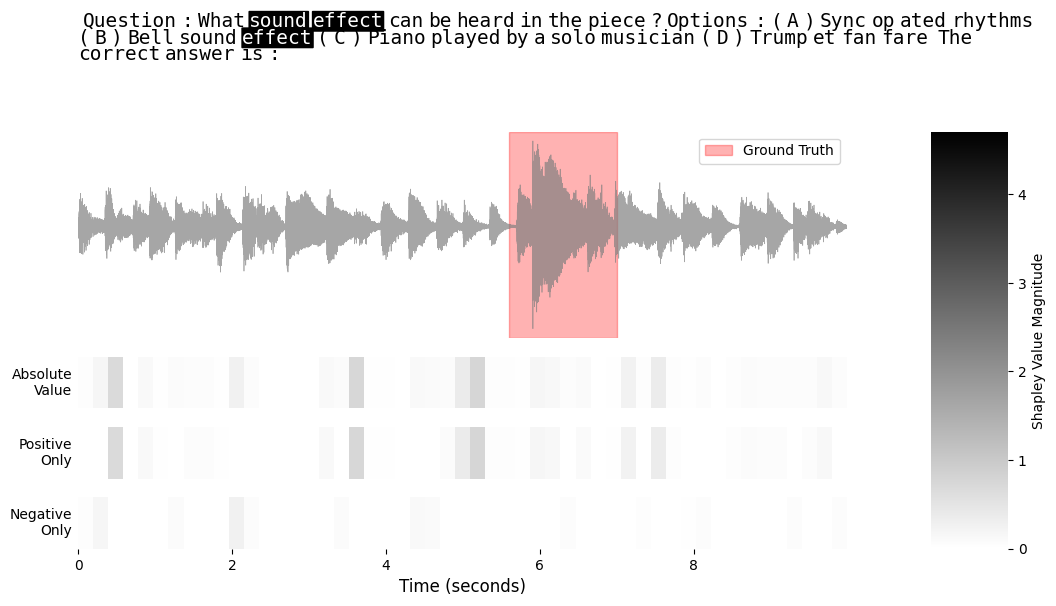

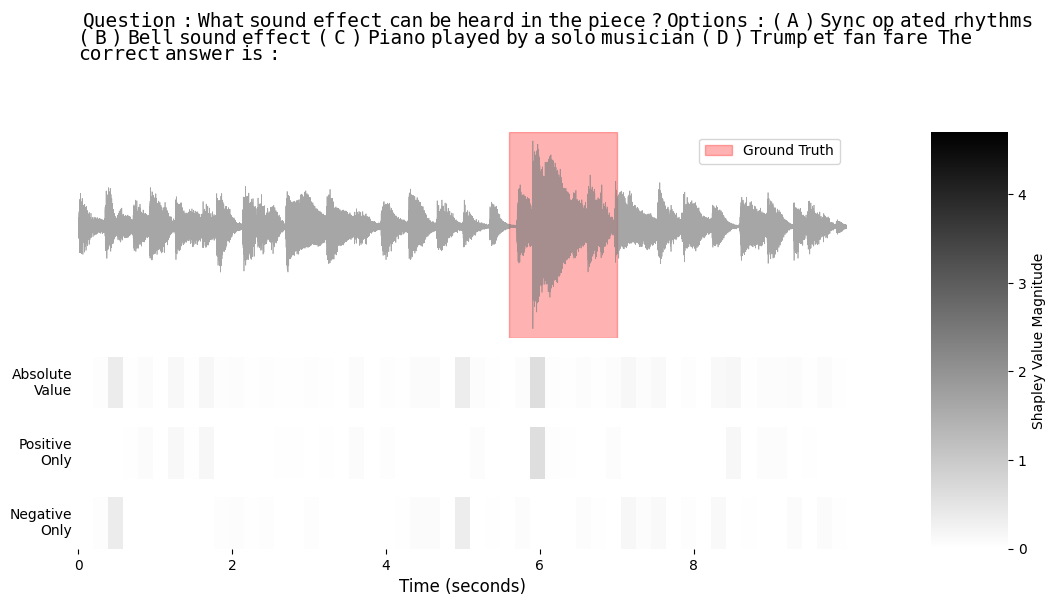

In [128]:
save_qual_results(sample)

text_max 4.7060546875, text_min -0.72894287109375, text_median -0.044921875
audio_max 0.7861328125, audio_min -0.3125, audio_median 0.0
max_abs_value 4.7060546875


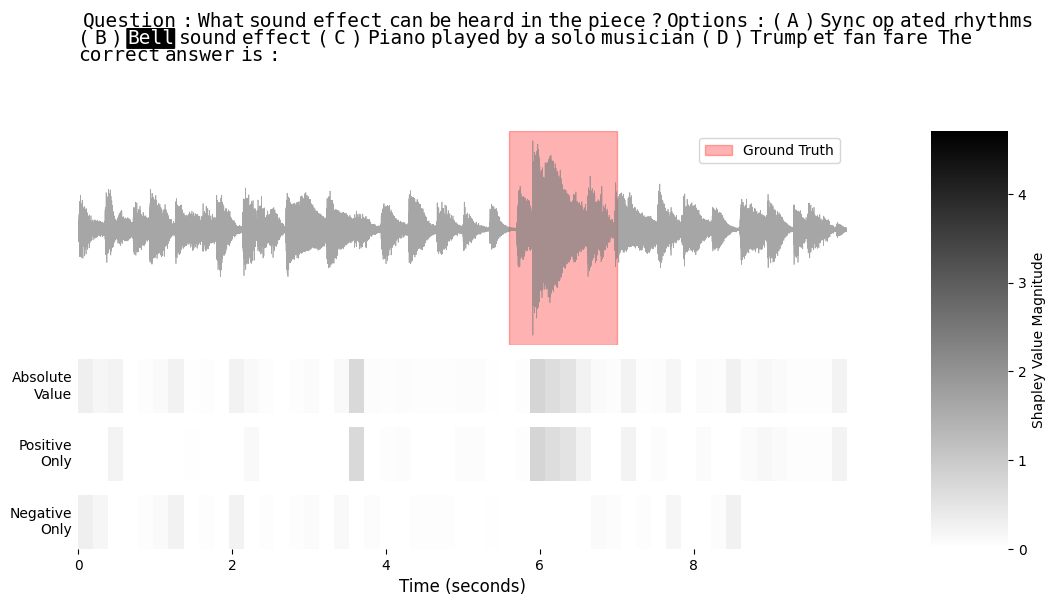

In [103]:
plots_improved.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=12,
        figsize=(12,7),
        colormap="binary",
        threshold=0.8, 
    )

text_max 10.5257568359375, text_min -7.430732727050781, text_median 1.42889404296875
audio_max 5.54736328125, audio_min -1.07513427734375, audio_median 0.325927734375
max_abs_value 10.5257568359375


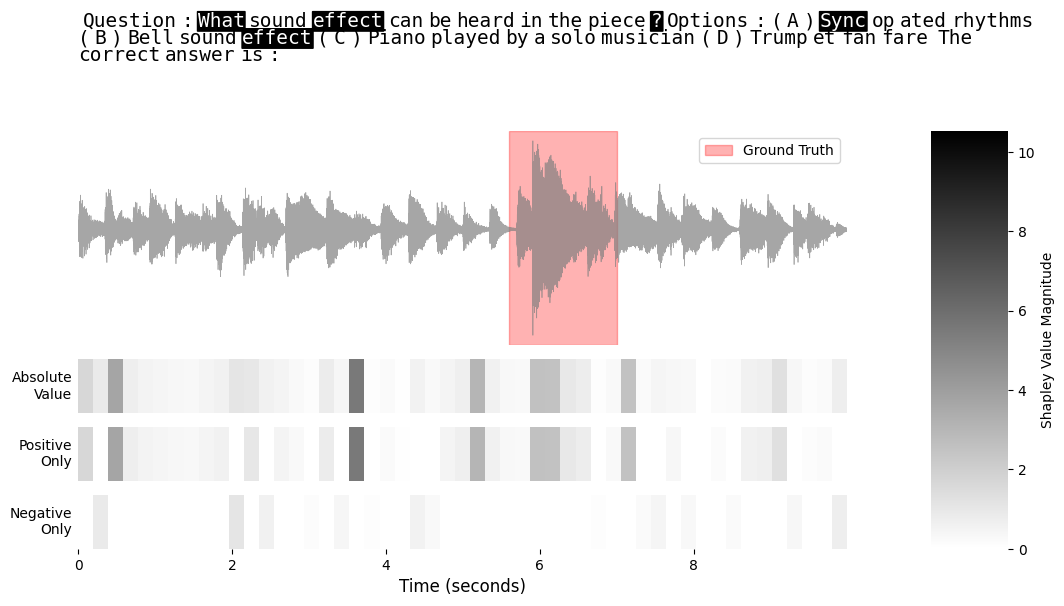

In [52]:
plots_improved.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=None,
        figsize=(12,7),
        colormap="binary",
        threshold=0.5, 
    )

---

qwen fs

In [77]:
sample = qfs.loc[719]

all_shapley_values, audio_shapley_values, question_shapley_values = get_shapley_values(sample)

x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=16000)
ipd.Audio(x, rate=fs)

text_max 4.0390625, text_min -0.626953125, text_median -0.015625
audio_max 0.490234375, audio_min -0.53515625, audio_median -0.0078125
max_abs_value 4.0390625


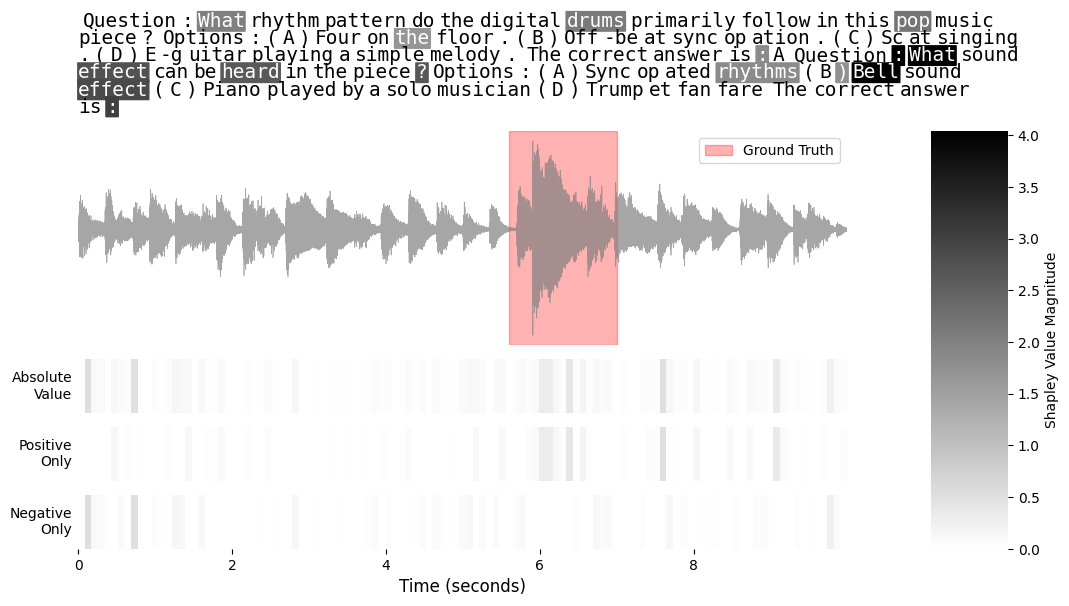

In [79]:
fig = plots_improved.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=12,
        figsize=(12,7),
        colormap="binary",
        threshold=0.1, 
    )

In [81]:
fig

In [80]:
plt.savefig("test.png")

<Figure size 640x480 with 0 Axes>

text_max 12.337158203125, text_min -7.35107421875, text_median 0.3212890625
audio_max 5.52490234375, audio_min -2.9521484375, audio_median 0.133544921875
max_abs_value 12.337158203125


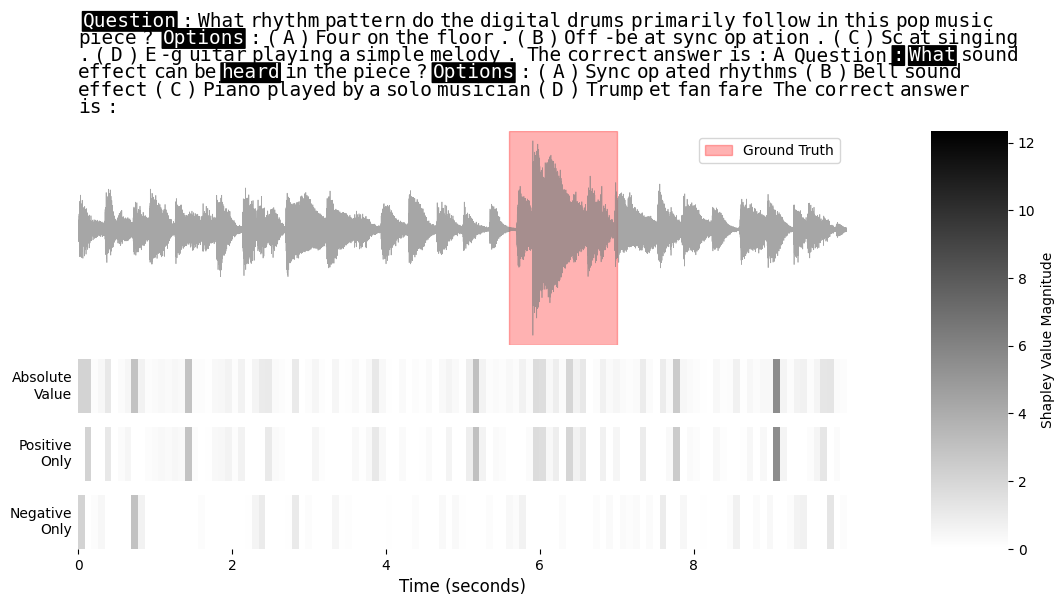

In [44]:
plots_improved.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=None,
        figsize=(12,7),
        colormap="binary",
        threshold=0.5, 
    )

---

text_max 4.7060546875, text_min -2.556640625, text_median 0.0458984375
audio_max 0.7861328125, audio_min -0.486328125, audio_median 0.017333984375
max_abs_value 15.2593994140625


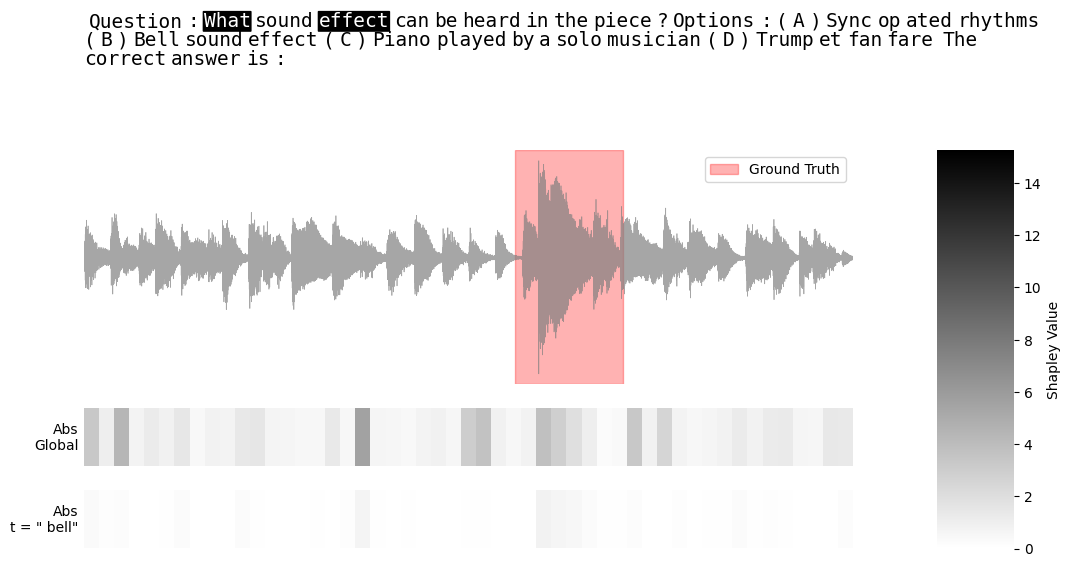

In [93]:
plots_improved.global_vs_local(
    token_idx=12,
    token_val=sample["output_tokens"][12],
    text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        figsize=(12,7),
        colormap="binary",
        intensity_threshold=0.7, 
)